In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

In [40]:
# Constants
thetas = np.array([0.5, 1]) # in radians (should be in [0, pi/2])
n_sources = len(thetas)
w0 = np.pi / 4
n_mics = 20
mic_distance = 1
wavelength = 1
noise_var = 1
fs = 1
n_samples = 100

## Crafting the signal

In [41]:
def narrowband_signal(k, w0):    
    def helper(t):
        # Use a hash as a seed to ensure that if (k1, t1) = (k2, t2), then we give the exact result
        rng = np.random.RandomState(hash((k, t)) & 0xffffffff)
        return rng.randn() * np.exp(-1j * w0 * t)
    return helper

def received_signal(thetas, narrowband_signals, mic_index, mic_distance=0.2, noise_var=0, wavelength=1):
    def helper(t):
        signal = 0
        for theta, narrowband in zip(thetas, narrowband_signals):
            phase = np.exp(-2j * np.pi * (mic_index - 1) * mic_distance * np.sin(theta) / wavelength)
            signal += narrowband(t) * phase
            
        return signal + np.random.normal(size=2, scale=noise_var).view(np.complex128)[0]
    
    return helper

In [42]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(thetas, narrowband_signals, m+1, 
                                    mic_distance=mic_distance, noise_var=noise_var, wavelength=wavelength) for m in range(n_mics)]

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(20, 100)

In [43]:
def music(samples, n_sources):
    M = len(samples)
    
    samples = (samples.T - samples.mean(axis=1).T).T

    print('Samples shape:', samples.shape)
    covariance = samples @ samples.conj().T / M
    print("Covariance shape:", covariance.shape)
        
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
        
    indices = np.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[indices], eigenvectors[:, indices]
    
    # Decompose signal and noise
    # Assumption : the noise has the smallest eigenvalues
    signal_eigenvalues, signal_eigenvectors = eigenvalues[-n_sources :], eigenvectors[:, -n_sources :]
    noise_eigenvalues, noise_eigenvectors = eigenvalues[: -n_sources], eigenvectors[:, : -n_sources]
    
    return signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors


def spectrum_function(noise_eigenvectors, mic_distance, wavelength):    
    M = noise_eigenvectors.shape[0]
    def helper(sin_value):
        phi = 2 * np.pi * mic_distance * sin_value / wavelength
        x = [np.exp(-1j*phi)]
        a = np.vander(x, M, increasing=True)
        temp = a.conj() @ noise_eigenvectors
        
        return 1 / np.linalg.norm(temp)**2
    
    return helper

In [44]:
def general_spectrum_function(noise_eigenvectors, mic_locations, wavelength):
    M = noise_eigenvectors.shape[0]
    def helper(theta):
        a = np.array([np.cos(theta), np.sin(theta)])
        atheta = np.exp(-1j*2*np.pi/wavelength*np.dot(mic_locations, a))
        temp = atheta.conj() @ noise_eigenvectors
        
        return 1 / np.linalg.norm(temp)**2
    
    return helper

Samples shape: (20, 100)
Covariance shape: (20, 20)


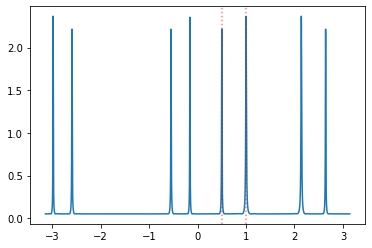

In [45]:
signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors = music(sampled_received, n_sources)

# spectrum = spectrum_function(noise_eigenvectors, mic_distance=mic_distance, wavelength=wavelength)

mic_locations = np.array([np.array([0, mic_distance * i]) for i in range(n_mics)])
spectrum = general_spectrum_function(noise_eigenvectors, mic_locations, wavelength)

X = np.linspace(-np.pi, np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [37]:
def extract_frequencies(spectrum, n_sources, input_range, resolution=1000):
    X = np.linspace(input_range[0], input_range[1], resolution)
    Y = np.array([spectrum(x) for x in X])
    
    threshold = np.sort(Y)[int(0.8 * resolution)]
    
    peak_indices, _ = find_peaks(Y, threshold)
    indices = np.argsort(Y[peak_indices])[-n_sources:]  # Sort peak indices by y value and take the top num_peaks    
    estimated_freq = peak_indices[indices]
    
    return (estimated_freq / resolution) * (input_range[1] - input_range[0]) + input_range[0]

In [48]:
estimated_thetas = extract_frequencies(spectrum, n_sources, [0, np.pi / 2])
estimated_thetas

array([0.49794244, 0.99902646])

## PyRoomAccoustics test

In this section we will test our pipeline with the pra module

In [10]:
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython

In [11]:
c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]
radius=4e-1
mic_distance = 4e-1
start = 4
n_mics = 6

snr_db = 1.5
distance = 3.  # meters idk wtf is happening
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2
# sigma2 = 0.01

### Placing the microphones

Coordinates of the microphones

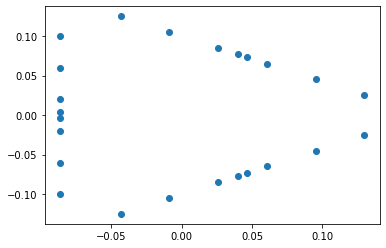

In [12]:
import json

with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])
plt.show()

In [13]:
microphone_2D_locations = microphone_2D_locations - microphone_2D_locations[0,:]

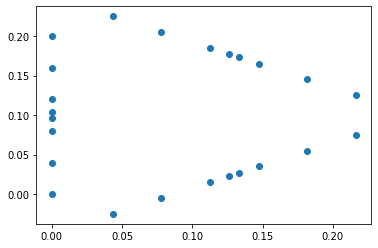

In [14]:
plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])

### Creating the room

(<Figure size 432x288 with 1 Axes>, <Axes: >)

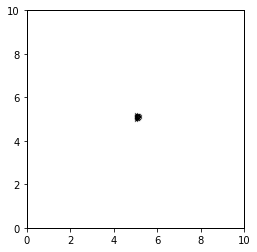

In [15]:
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# Adding the microphones

mics_coords = (microphone_2D_locations + room_dim / 2).T
aroom.add_microphone_array(pra.MicrophoneArray(mics_coords, aroom.fs))

# echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=37.5e-3)
# echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)
# aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

aroom.plot()

### Adding the source

(<Figure size 432x288 with 1 Axes>, <Axes: >)

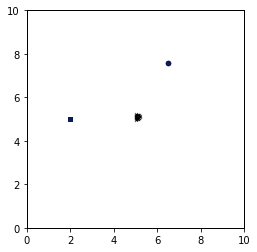

In [16]:
# Add sources of 1 second duration
azimuth = np.array([60., 180]) / 180. * np.pi

rng = np.random.RandomState(23)
duration_samples = 10000

for ang in azimuth:
    random_phase = np.random.uniform(0, 2 * np.pi)
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    # source_signal = [rng.randn(duration_samples) for t in range(fs)]
    source_signal = rng.randn(duration_samples)
    # source_signal = [5 * np.sin(t * 2 * np.pi / fs) for t in range(duration_samples)]
    aroom.add_source(source_location, signal=source_signal)
    
# Run the simulation
aroom.simulate()
aroom.plot()

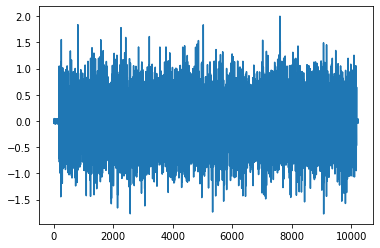

In [17]:
plt.plot(aroom.mic_array.signals[0])
# plt.plot(aroom.mic_array.signals[0][:220])
plt.show()

Samples shape: (24, 10232)
Covariance shape: (24, 24)


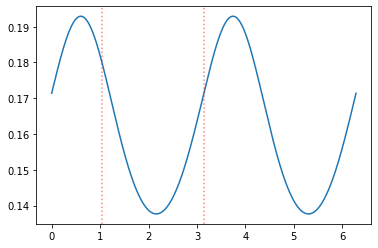

In [18]:
n_sources = len(azimuth)

signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors = music(aroom.mic_array.signals[: duration_samples], 2)
spectrum = general_spectrum_function(noise_eigenvectors, mics_coords.T, wavelength)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [19]:
test = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)

In [20]:
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])
doa = pra.doa.algorithms["MUSIC"](mics_coords, fs, nfft, c=c, num_src=2, max_four=4)
doa.locate_sources(X, freq_range=freq_range)
spatial_resp = doa.grid.values

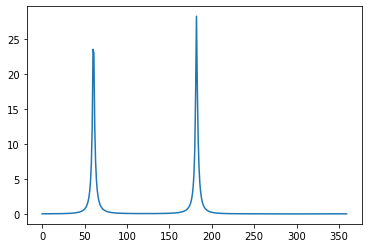

In [21]:
plt.plot(spatial_resp)